<a href="https://colab.research.google.com/github/MargaretZhou/MISA-Bootcamp-2021/blob/main/Santa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [89]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import keras
from keras.layers import Conv2D,Flatten,Dense,MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

#!pip install dask[bag] --upgrade
import dask.bag as bag
from dask import diagnostics

import skimage
from skimage import data, io, filters, color, exposure
from skimage.transform import rotate

import PIL

import os
from glob import glob

# Connect to Google Drive to access data

Note sure how else to access data besides using Google Drive. But you can upload data into drive, mount drive and access data from drive.

Already created a data folder called 432DeepLearning_SantaData. Link here:
https://drive.google.com/drive/u/0/folders/1N0cZ-UM4h124fx6l4SRpmOcKkfGlnmuA

In [ ]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Mounted at /content/drive


# Load Data

### For EDA

In [ ]:
train_dir = './drive/MyDrive/432DeepLearning_SantaData/is_that_santa/train' # train image folder
test_dir = './drive/MyDrive/432DeepLearning_SantaData/is_that_santa/test' # test image folder

# get the list of jpegs from sub image class folders
santa_train = [fn for fn in os.listdir(f'{train_dir}/santa') if fn.endswith('.jpg')]
nonsanta_train = [fn for fn in os.listdir(f'{train_dir}/not-a-santa') if fn.endswith('.jpg')]
santa_test = [fn for fn in os.listdir(f'{test_dir}/santa') if fn.endswith('.jpg')]
nonsanta_test = [fn for fn in os.listdir(f'{test_dir}/not-a-santa') if fn.endswith('.jpg')]

# Can load data later

### For modeling

Images are augmented

In [ ]:
train_generator = ImageDataGenerator(rescale = 1/255)
test_generator = ImageDataGenerator(rescale = 1/255)

In [ ]:
trainset = train_generator.flow_from_directory(r"./drive/MyDrive/432DeepLearning_SantaData/is_that_santa/train",target_size = (150,150),class_mode='binary',batch_size=80)
testset = test_generator.flow_from_directory(r"./drive/MyDrive/432DeepLearning_SantaData/is_that_santa/test",target_size = (150,150),class_mode = 'binary',batch_size= 20)

Found 614 images belonging to 2 classes.
Found 616 images belonging to 2 classes.


# EDA on train

Source: https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2

### Train and test length for each class

Completely balanced

In [ ]:
# check the number of files in train
len(santa_train), len(nonsanta_train)

(307, 307)

In [ ]:
# check the number of files in test
len(santa_test), len(nonsanta_test)

(308, 308)

### Take a look at a few samples from santa and nonsanta class

Few priests in test set look awfully like santas

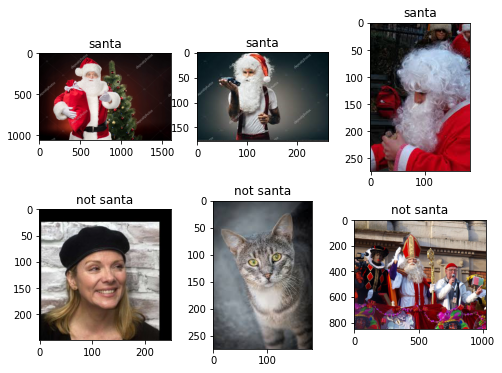

In [58]:
# randomly select 3 of each
select_santa = np.random.choice(santa_train, 3, replace = False)
select_nonsanta = np.random.choice(nonsanta_train, 3, replace = False)

# plotting 2 x 3 image matrix
fig = plt.figure(figsize = (8,6))
for i in range(6):
    if i < 3:
        fp = f'{train_dir}/santa/{select_santa[i]}'
        label = 'santa'
    else:
        fp = f'{train_dir}/not-a-santa/{select_nonsanta[i-3]}'
        label = 'not santa'
    ax = fig.add_subplot(2, 3, i+1)
    
    # to plot without rescaling, remove target_size
    fn = image.load_img(fp)
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    #plt.axis('off')
plt.show()

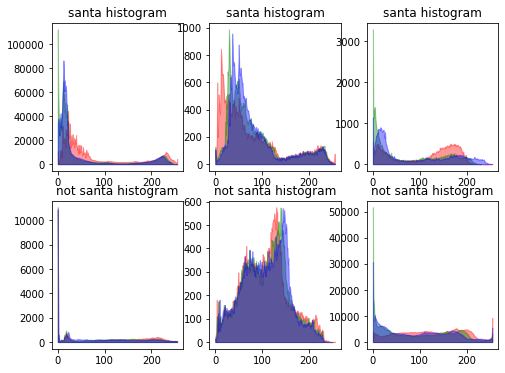

In [59]:
#RGB histogram for some of santa pictures

# plotting 2 x 3 histogram matrix
fig = plt.figure(figsize = (8,6))
for i in range(6):
    if i < 3:
        fp = f'{train_dir}/santa/{select_santa[i]}'
        label = 'santa histogram'
    else:
        fp = f'{train_dir}/not-a-santa/{select_nonsanta[i-3]}'
        label = 'not santa histogram'
    ax = fig.add_subplot(2, 3, i+1)
    
    # to plot without rescaling, remove target_size
    fn = io.imread(fname = fp)
    for col, channel in zip('rgb', np.rollaxis(fn, axis=-1)):
      hist, bin_centers = exposure.histogram(channel)
      plt.fill_between(bin_centers, hist, color=col, alpha=0.4)
    plt.title(label)
plt.show()

### Checking image size

[########################################] | 100% Completed | 10.8s
[########################################] | 100% Completed |  6.9s


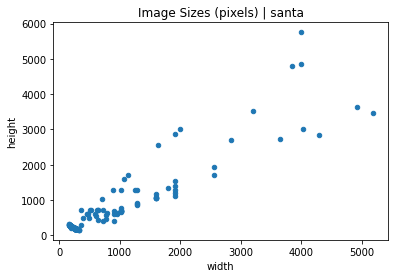

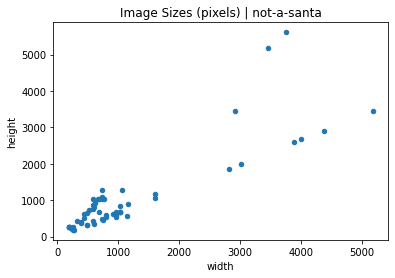

In [60]:
directories = {'santa' : './drive/MyDrive/432DeepLearning_SantaData/is_that_santa/train/santa/',
               'not-a-santa' : './drive/MyDrive/432DeepLearning_SantaData/is_that_santa/train/not-a-santa/'}

def get_dims(file):
  '''Returns dimenstions for an RBG image'''
  im = Image.open(file)
  arr = np.array(im)
  #h,w,d = arr.shape
  h = arr.shape[0]
  w = arr.shape[1]
  return h,w

for n,d in directories.items():
  filepath = d
  filelist = [filepath + f for f in os.listdir(filepath)]
  dims = bag.from_sequence(filelist).map(get_dims)
  with diagnostics.ProgressBar():
    dims = dims.compute()
    dim_df = pd.DataFrame(dims, columns=['height', 'width'])
    sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
    sizes.plot.scatter(x='width', y='height');
    plt.title('Image Sizes (pixels) | {}'.format(n))

### Find outlier

### Turn images into matrix based on pixels (numpy array)

https://towardsdatascience.com/simplifing-image-outlier-detection-with-alibi-detect-6aea686bf7ba

In [75]:
# making n X m matrix
def img2np(path, list_of_filename, size = (100, 100)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = Image.open(fp).convert("RGB").resize(size)
        # covert image to a matrix
        img_ts = np.array(current_image)
        #print(img_ts.shape)
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

# run it on our folders
santa_pixels_train = img2np(f'{train_dir}/santa/', santa_train)
nonsanta_pixels_train = img2np(f'{train_dir}/not-a-santa/', nonsanta_train)

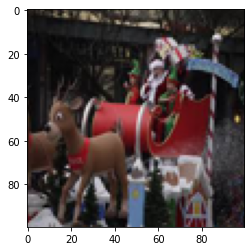

In [91]:
path = f'{train_dir}/santa/'
fp = path + santa_train[0]
#print(fp)

fn = Image.open(fp).convert("RGB").resize((100,100))
img = np.asarray(fn)
plt.imshow(img)

### Get image average

[[146.07661238 131.85615635 127.56807818 146.92713355 132.4276873
  128.02332248 147.45752443 132.77811075 128.23644951 147.35175896
  132.24550489 127.54690554 148.34931596 133.27162866 128.0734202
  148.55368078 132.8909772  127.51436482 148.29114007 131.89697068]
 [126.33485342 148.98325733 131.5670684  126.04208469 149.46107492
  131.50361564 125.97221498 149.73667752 131.14517915 125.68579805
  150.30889251 130.8680456  125.33530945 150.73110749 130.63586319
  125.07413681 150.85807818 130.25778502 124.70452769 150.86583062]
 [129.5957329  123.9504886  150.5781759  128.752443   123.13762215
  151.23136808 128.82742671 123.07641694 151.56019544 128.92798046
  122.9713355  152.07570033 128.96758958 122.80449511 152.37456026
  128.53570033 122.23560261 152.77332248 128.402443   122.03185668]
 [153.22599349 128.62156352 122.21162866 153.81534202 128.7928013
  122.3052443  153.95107492 128.56625407 122.21570033 154.51885993
  128.47517915 122.20752443 155.96117264 129.43954397 123.0770

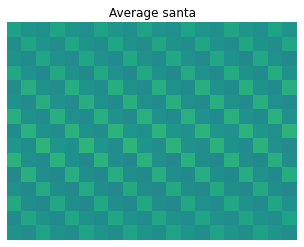

[[101.95967427  93.04557003  85.60615635 104.85648208  95.66003257
   88.11508143 107.03501629  97.53260586  89.81850163 108.9228013
   99.13599349  91.11100977 109.86605863  99.81315961  91.61850163
  110.68315961 100.60693811  92.44201954 111.22863192 101.36452769]
 [ 93.26263844 111.61299674 101.99615635  93.95068404 111.57517915
  102.1052443   94.11117264 111.65254072 102.21423453  94.25703583
  112.22583062 102.60390879  94.5137785  112.60439739 102.82361564
   94.7067101  112.45752443 102.77127036  94.64736156 112.13550489]
 [102.5834202   94.28355049 111.98208469 102.29566775  93.93286645
  112.09309446 102.21364821  93.70859935 111.51879479 101.42521173
   92.8585342  110.74257329 100.44263844  91.92446254 110.08403909
   99.77348534  91.24498371 109.67214984  99.44785016  90.74263844]
 [109.33267101  98.97892508  90.19003257 108.97944625  98.3357329
   89.51820847 108.29827362  97.44534202  88.58501629 107.55514658
   96.53798046  87.57863192 106.61527687  95.32625407  86.437

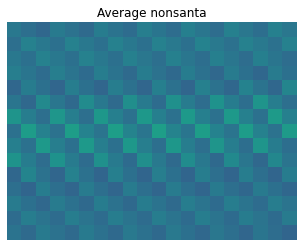

In [92]:

def find_mean_img(full_mat, title, size = (15, 20)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    print(mean_img)
    plt.imshow(mean_img, vmin=0, vmax=255)
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

santa_mean = find_mean_img(santa_pixels_train, 'santa')
nonsanta_mean = find_mean_img(nonsanta_pixels_train, 'nonsanta')

### Contrast between images

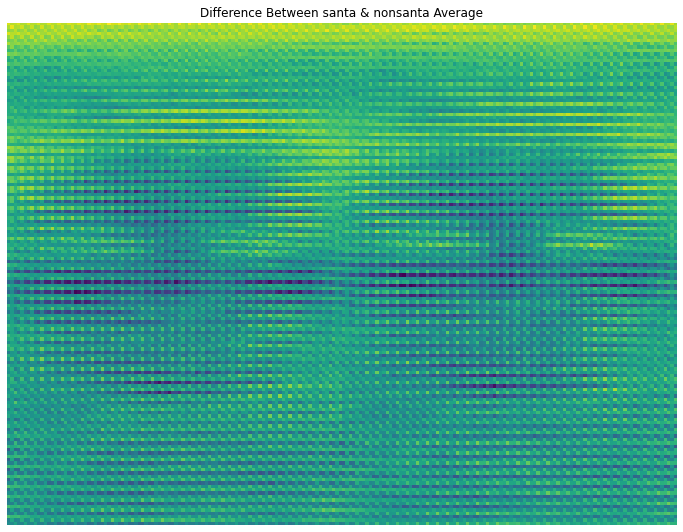

In [ ]:
contrast_mean = santa_mean - nonsanta_mean
plt.imshow(contrast_mean)
plt.title(f'Difference Between santa & nonsanta Average')
plt.axis('off')
plt.show()

### Variability

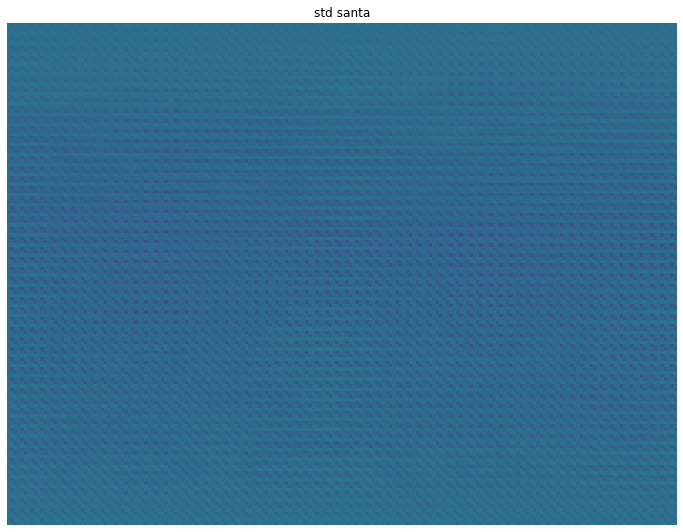

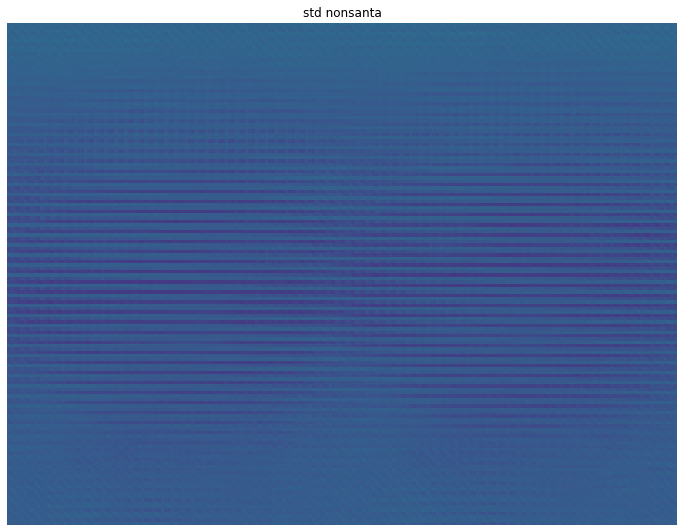

In [ ]:

def find_std_img(full_mat, title, size = (150, 200)):
    # calculate the average
    std_img = np.std(full_mat, axis = 0)
    # reshape it back to a matrix
    std_img = std_img.reshape(size)
    plt.imshow(std_img, vmin=0, vmax=255)
    plt.title(f'std {title}')
    plt.axis('off')
    plt.show()
    return std_img

santa_mean = find_std_img(santa_pixels_train, 'santa')
nonsanta_mean = find_std_img(nonsanta_pixels_train, 'nonsanta')

**bold text** # Style-Transfer

Use colors from Santa image - 269.Santa and 285.Santa (animated) - Style test set

Content transfer image - 234.not-a-santa --- test set

In [ ]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [ ]:
train_dir = './drive/MyDrive/432DeepLearning_SantaData/is_that_santa/train' # train image folder
test_dir = './drive/MyDrive/432DeepLearning_SantaData/is_that_santa/test' # test image folder

# get the list of jpegs from sub image class folders
santa_train = [fn for fn in os.listdir(f'{train_dir}/santa') if fn.endswith('.jpg')]
nonsanta_train = [fn for fn in os.listdir(f'{train_dir}/not-a-santa') if fn.endswith('.jpg')]
santa_test = [fn for fn in os.listdir(f'{test_dir}/santa') if fn.endswith('.jpg')]
nonsanta_test = [fn for fn in os.listdir(f'{test_dir}/not-a-santa') if fn.endswith('.jpg')]

# Can load data later

In [ ]:
santa_train[0]

'12.Santa.jpg'

In [ ]:
fp = f'{train_dir}/santa/{1}'

./drive/MyDrive/432DeepLearning_SantaData/is_that_santa/train/santa/571.Santa.jpg
./drive/MyDrive/432DeepLearning_SantaData/is_that_santa/train/santa/374.Santa.jpg
./drive/MyDrive/432DeepLearning_SantaData/is_that_santa/train/santa/50.Santa.jpg


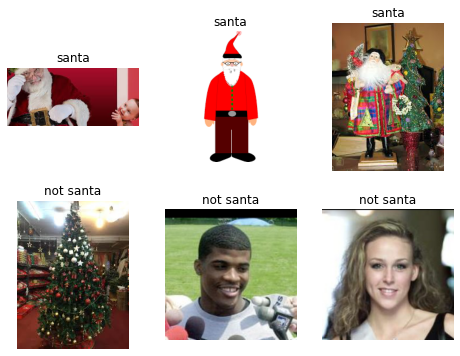

In [ ]:
# randomly select 3 of each
select_santa = np.random.choice(santa_train, 3, replace = False)
select_nonsanta = np.random.choice(nonsanta_train, 3, replace = False)

# plotting 2 x 3 image matrix
fig = plt.figure(figsize = (8,6))
for i in range(6):
    if i < 3:
        fp = f'{train_dir}/santa/{select_santa[i]}'
        print(fp)
        label = 'santa'
    else:
        fp = f'{train_dir}/not-a-santa/{select_nonsanta[i-3]}'
        label = 'not santa'
    ax = fig.add_subplot(2, 3, i+1)
    
    # to plot without rescaling, remove target_size
    fn = image.load_img(fp)
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.show()

In [ ]:

from tensorflow.keras import backend
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


NameError: ignored

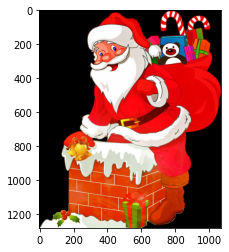

In [ ]:
fp = f'{test_dir}/santa/{"285.Santa.jpg"}'
fn = image.load_img(fp)
plt.imshow(fn, cmap='Greys_r')
plt.title(label)
plt.axis('off')
plt.show()

In [ ]:
# sourcing style image
#269.Santa
#285.Santa
style_image_dir = f'{test_dir}/santa/{"269.Santa.jpg"}'
style_image = Image.open(style_image_dir).resize((512,512))

# sourcing transfer image
transfer_image_dir = f'{test_dir}/not-a-santa/{"340.not-a-santa.jpg"}'
transfer_image = Image.open(transfer_image_dir).resize((512,512))


In [ ]:
content_array = np.asarray(transfer_image, "float32")
content_array = np.expand_dims(content_array, axis = 0)
content_array_cp = np.copy(content_array)

style_array = np.asarray(style_image, "float32")
style_array = np.expand_dims(style_array, axis = 0)
style_array_cp = np.copy(style_array)

content_array_cp[:,:,:,0] -= 103.939
content_array_cp[:,:,:,1] -= 116.779
content_array_cp[:,:,:,2] -= 123.68

style_array_cp[:,:,:,0] -= 103.939
style_array_cp[:,:,:,1] -= 116.779
style_array_cp[:,:,:,2] -= 123.68

content_array_cp = content_array_cp[:,:,:, ::-1]
style_array_cp = style_array_cp[:,:,:, ::-1]

In [ ]:
style_array_cp.shape

(1, 512, 512, 3)

In [ ]:
content_variable = backend.variable(content_array_cp)
style_variable = backend.variable(style_array_cp)

# placeholder creates an empty tensor with the shape
combination_variable = backend.placeholder(shape = content_array_cp.shape)

# tensor variable to be input for the deep learning model
tensor_variable = backend.concatenate([ content_variable, style_variable, combination_variable], axis = 0)

  <tf.Variable 'Variable:0' shape=(1, 512, 512, 3) dtype=float32>. This is a strong indication that the Lambda layer should be rewritten as a subclassed Layer.


  <tf.Variable 'Variable:0' shape=(1, 512, 512, 3) dtype=float32>. This is a strong indication that the Lambda layer should be rewritten as a subclassed Layer.


In [ ]:
combination_variable.shape, style_variable.shape, content_variable.shape
tensor_variable

<KerasTensor: shape=(3, 512, 512, 3) dtype=float32 (created by layer 'tf.concat_6')>

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg_model = VGG16(input_tensor = tensor_variable, weights = "imagenet", include_top = False)

# see all the layers in the model excluding the fully connected layers
vgg_model.layers

# Create a dictionary so we can call the layer by its layer name  
layers  = dict([(layer.name, layer.output) for layer in vgg_model.layers])

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
def calculate_content_loss(content, combination):
    return backend.sum(backend.square(content - combination))
    
layer_features = layers["block2_conv2"]
print(layer_features)
content_image_features = layer_features[0,:,:,:]
combination_image_features = layer_features[2,:,:,:]
print(content_image_features)

KerasTensor(type_spec=TensorSpec(shape=(3, 256, 256, 128), dtype=tf.float32, name=None), name='block2_conv2/Relu:0', description="created by layer 'block2_conv2'")
KerasTensor(type_spec=TensorSpec(shape=(256, 256, 128), dtype=tf.float32, name=None), name='tf.__operators__.getitem/strided_slice:0', description="created by layer 'tf.__operators__.getitem'")


In [ ]:
def calculate_gram_matrix(matrix):
    features = backend.batch_flatten(backend.permute_dimensions(matrix, (2, 0, 1)))
    return backend.dot(features, backend.transpose(features))

def calculate_style_loss(style, combination):
    style_gram = calculate_gram_matrix(style)
    combination_gram = calculate_gram_matrix(combination)
    channels = 3
    size = 512 * 512 ## height * width
    return backend.sum(backend.square(style_gram - combination_gram)) / (4. * (channels **2) * (size ** 2))

feature_layers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]

In [ ]:
content_weight = 0.025
style_weight = 2.5
total_variation_weight = 1

In [ ]:
loss = backend.variable(0.)

# Add content loss with block2_conv2
layer_features = layers["block2_conv2"]
content_image_features = layer_features[0,:,:,:]
combination_image_features = layer_features[2,:,:,:]
loss = loss + (content_weight * calculate_content_loss(content_image_features, combination_image_features))

# Add style loss
feature_layers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]

for i in feature_layers:
    layer_features = layers[i]
    style_image_features = layer_features[1,:,:,:]
    combination_image_features = layer_features[2,:,:,:]
    style_loss = calculate_style_loss(style_image_features, combination_image_features)
    loss = loss + (style_weight/ len(feature_layers))*style_loss
		
# Add total variation loss
def total_variation_loss(tensor):
    a = backend.square(tensor[:, :511, :511, :] - tensor[:, 1:, :511, :])
    b = backend.square(tensor[:, :511, :511, :] - tensor[:, :511, 1:, :])
    return backend.sum(backend.pow(a+b, 1.25))
loss= loss + total_variation_weight*total_variation_loss(combination_variable)


In [ ]:
tf.compat.v1.disable_eager_execution()
grads = backend.gradients(loss, combination_variable)

output = [loss]

if type(grads) in {tuple, list}:
    output+=grads
else:
    output.append(grads)
    
f_outputs = backend.function([combination_variable], output)

https://stackoverflow.com/questions/58271820/how-to-replace-keras-gradients-function-with-gradienttape-in-tf2-0 

TypeError: ignored

In [ ]:
f_outputs = backend.function([combination_variable], output)

NameError: ignored

In [ ]:
def eval_loss_and_grads(tensor):
    tensor = tensor.reshape((1, 512, 512, 3))
    outs = f_outputs([tensor])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values  = outs[1].flatten().astype("float64")
    else:
        grad_values  = np.array(outs[1:]).flatten().astype("float64")
    return loss_value, grad_values
class Evaluator:
    
    def __init__(self):
        self.loss_value = None
        self.grad_values = None
        
    def loss(self ,x):
        assert self.loss_value is None
        self.loss_value, self.grad_values = eval_loss_and_grads(x)
        return self.loss_value
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
evaluator = Evaluator()

In [ ]:
import time
from scipy.optimize import fmin_l_bfgs_b

x = np.random.uniform(0, 255, (1, 512, 512, 3)) - 128.

iterations = 10

for i in range(iterations):
    print("iternation #", i)
    start = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime = evaluator.grads, maxfun = 30)
    print("current_loss", min_val)
    end = time.time()
    print("iteration completed in ", end - start)

iternation # 0


NameError: ignored

In [ ]:
x = x.reshape((512,512,3))
x = x[:,:,::-1]
x[:,:,0]+=103.939
x[:,:,1]+= 116.779
x[:,:,2]+= 123.68
x = np.clip(x, 0, 255).astype("uint8")

Image.fromarray(x)

**bold text**